In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import imutils
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [4]:
#Reading using pandas
train_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-train.csv', header=None)
valid_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-test.csv', header=None)


In [5]:
# Add test dataset into train dataset
df = pd.concat([train_df, valid_df], ignore_index=True)

In [6]:
# Reading the file
label_map = pd.read_csv("./dataset/EMNIST/emnist-balanced-mapping.txt",
                        delimiter=' ',
                        index_col=0,
                        header=None)


label_map = label_map.iloc[:, 0]

# Initializing an empty dictionary
label_dictionary = {}

# Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    char_value = chr(label)
    if 'A' <= char_value <= 'Z':
        label_dictionary[index] = char_value

label_dictionary

{10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z'}

In [7]:
df.shape


(131600, 785)

In [8]:
# Filter the DataFrame to include only rows where the label is an uppercase letter
df_filtered = df[df[0].between(10, 35, inclusive='both')]

# Check the shape of the filtered DataFrame
df = df_filtered
del df_filtered

In [11]:
df.describe()



,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,72798.000000,72798.0,72798.0,72798.0,72798.0,72798.000000,72798.000000,72798.000000,72798.000000,72798.000000,...,72798.000000,72798.0,72798.0,72798.000000,72798.000000,72798.0,72798.0,72798.0,72798.0,72798.0
mean,22.500192,0.0,0.0,0.0,0.0,0.003681,0.022789,0.033476,0.028971,0.028696,...,0.000481,0.0,0.0,0.003352,0.000440,0.0,0.0,0.0,0.0,0.0
std,7.500042,0.0,0.0,0.0,0.0,0.397269,1.763981,2.095241,2.042100,2.181759,...,0.129720,0.0,0.0,0.904337,0.118602,0.0,0.0,0.0,0.0,0.0
min,10.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,16.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,29.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,35.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


### Preprocessing data


In [141]:
# Is there any missing values
df.dropna(inplace=True)
num_missing_values = df.isnull().sum().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)
num_duplicates = df.duplicated().sum()

# Make sure the grayscale values to be between 0 and 255
df = np.clip(df, 0, 255)
num_values_outside_range = ((df < 0) | (df > 255)).sum().sum()

# Check if we have any null values or duplicated rows or values outside (0, 255) range.
print(f"Any missing value? {num_missing_values}")
print(f"Any duplicates? {num_duplicates}")
print(f"Any values outside the range of 0 and 255? {num_values_outside_range}")
print(df)

Any missing value? 0
Any duplicates? 0
Any values outside the range of 0 and 255? 0
        0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
3        15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
6        26    0    0    0    0    0    0    0    0    0  ...    0    0    0   
7        32    0    0    0    0    0    0    0    0    0  ...    0    0    0   
8        20    0    0    0    0    0    0    0    0    0  ...    0    0    0   
12       15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
131591   23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
131592   29    0    0    0    0    0    0    0    0    0  ...    0    0    0   
131596   15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
131598   26    0    0    0    0    0    0    0    0    0  ...    0    0    0   
131599   33    0    0    0    0    0

In [142]:
# We split our dataframe into feature matrix (X) and target vector (y)
X = df.loc[:, 1:]
y = df.loc[:, 0]

X.shape, y.shape

((72798, 784), (72798,))

In [143]:
#Data Scaling to bring the input values between 0 to 1
X = X.astype('float32') / 255


In [144]:
# Sample entry number 263
sample_image = X.iloc[42]
sample_label = y.iloc[42]
sample_image.shape, sample_label

((784,), 34)

Label entry No. 42: Y


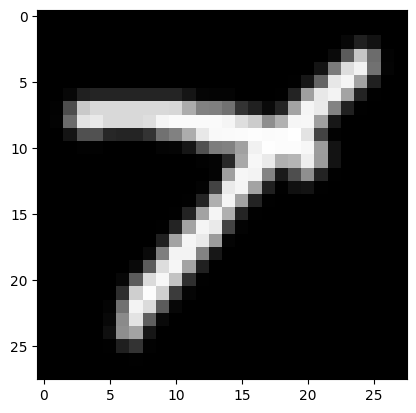

In [145]:
print("Label entry No. 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

In [146]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

Label entry 42: Y


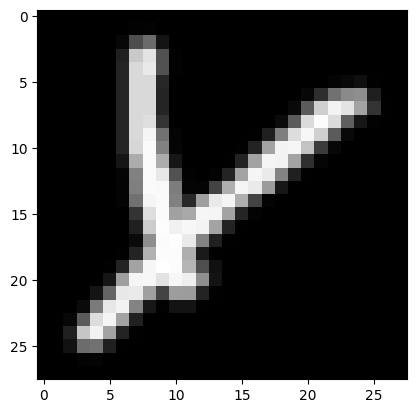

In [147]:
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [148]:
# Next we want to apply reshape_and_rotate to all images in X_train
X = np.asarray(X)
X = np.apply_along_axis(flip_and_rotate, 1, X)
X.shape

(72798, 28, 28)

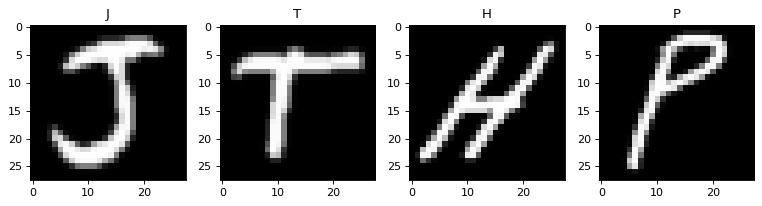

In [149]:
plt.figure(figsize=(12, 6), dpi=80)  # Adjust the figure size to accommodate two rows
for i in range(12, 16):
    plt.subplot(2, 5, i-11)  # Use 2 rows and 5 columns for displaying the samples
    plt.imshow(X[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y.iloc[i]])
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [150]:
print(np.unique(y))

#Finding the number of output columns
number_of_classes = y.nunique()
number_of_classes
print(y.shape)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35]
(72798,)


In [151]:
#One hot encoding of numpy array\
y = y - 10 # Assuming your labels are in the range [10, 35] -> Mapping
y = to_categorical(y, number_of_classes)
y.shape
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [152]:
# Reshaping the train data
# As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train
X = X.reshape(-1, 28, 28, 1)
X.shape

(72798, 28, 28, 1)

In [153]:
# Split 20% validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                  y, 
                                                  test_size= 0.2,
                                                  stratify = y,
                                                  random_state=42, shuffle=True)


### Initial Basic Model (Nur)

In [154]:
# model = Sequential(
#     [              
#         tf.keras.Input(shape=(28, 28, 1)),
#         Dense(25, activation='relu', name='layer1'),
#         Dense(15, activation='relu', name='layer2'),
#         Dense(10, activation='linear', name='layer3'),
#     ], name = "my_model" 
# )
# model.summary()

### Initial CNN Model

In [155]:
# # Define the model
# model = Sequential()

# # Flatten the output of the last convolutional layer
# model.add(Flatten(input_shape=(28, 28, 1)))

# # Fully connected layers
# model.add(Dense(256, activation='relu'))
# model.add(Dense(84, activation='relu'))

# # Dropout layer for regularization
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(number_of_classes, activation='softmax'))

# # Display the summary of the model
# model.summary()

### Final CNN model

In [156]:
model = Sequential()

model.add(Conv2D(256, (3, 3), padding = "same", activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(number_of_classes, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 256)       2560      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 128)       295040    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 2, 2, 64)       

In [157]:
# Compile the model with categorical cross-entropy loss, the specified optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Create a ModelCheckpoint callback to save the best model during training based on validation loss
mcp_save = ModelCheckpoint('./saved/nn_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

# Create a ReduceLROnPlateau callback to reduce the learning rate if validation loss plateaus for 3 epochs
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)


In [158]:
# Model Fitting
history = model.fit(X_train,  # Training data features
                    y_train,  # Training data labels
                    epochs=20,  # Number of epochs for training the model
                    batch_size=32,  # Number of samples per gradient update
                    verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
                    validation_data=(X_valid, y_valid),  # Validation data for evaluating the model
                    callbacks=[mcp_save, early_stopping, RLP])  # Callbacks for additional functionality during training

Epoch 1/20
1820/1820 [==============================] - ETA: 0s - loss: 1.1353 - accuracy: 0.6400
Epoch 1: val_loss improved from inf to 0.31956, saving model to ./saved\nn_model.h5
1820/1820 [==============================] - 24s 13ms/step - loss: 1.1353 - accuracy: 0.6400 - val_loss: 0.3196 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 2/20
1818/1820 [============================>.] - ETA: 0s - loss: 0.5020 - accuracy: 0.8393
Epoch 2: val_loss improved from 0.31956 to 0.24139, saving model to ./saved\nn_model.h5
1820/1820 [==============================] - 22s 12ms/step - loss: 0.5019 - accuracy: 0.8394 - val_loss: 0.2414 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 3/20
1819/1820 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8748
Epoch 3: val_loss improved from 0.24139 to 0.22051, saving model to ./saved\nn_model.h5
1820/1820 [==============================] - 22s 12ms/step - loss: 0.3906 - accuracy: 0.8748 - val_loss: 0.2205 - val_accuracy: 0.9270 - lr: 0.0010
Ep

In [159]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

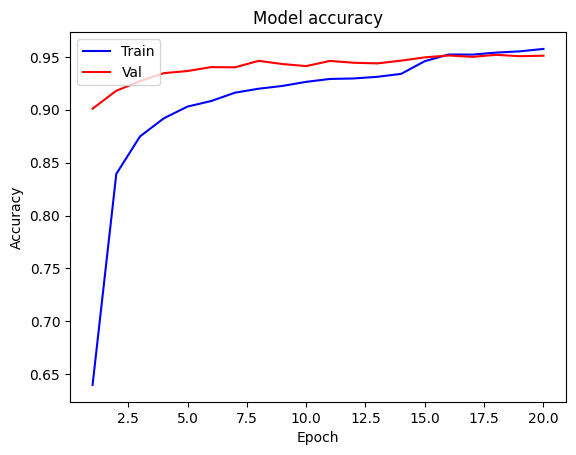

In [160]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

Loss Curve


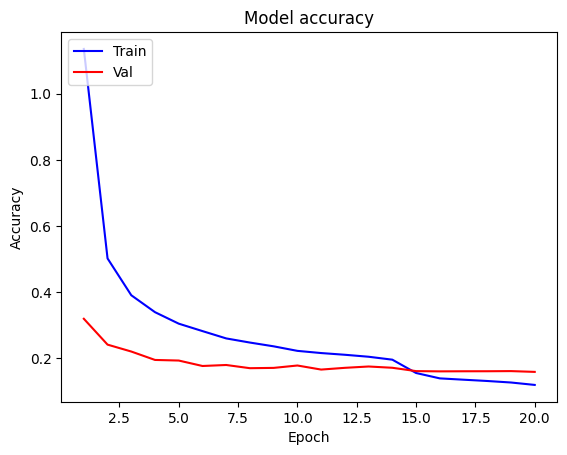

In [161]:
# loss curve
print('Loss Curve')
plotgraph(epochs, loss, val_loss)

### Segmentation and Validation

In [171]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [178]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # Loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1, 28, 28, 1)
        ypred = model.predict(thresh)
        # Assuming ypred is a one-hot encoded vector or probability distribution
        # Decode the prediction without using LabelBinarizer
        predicted_class = np.argmax(ypred)
        letters.append(predicted_class)

    return letters, image

In [173]:
def get_word(letter):
    word = "".join([label_dictionary[label+10] for label in letter])
    return word

1/1 [==============================] - 0s 30ms/step
The model's prediction is:  BENES


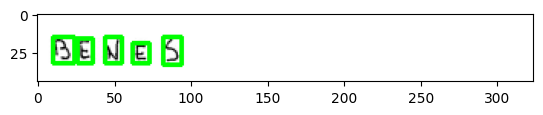

In [165]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00003.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 32ms/step
The model's prediction is:  LILOU


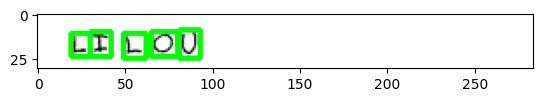

In [166]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00023.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 25ms/step
The model's prediction is:  JAFFEUX


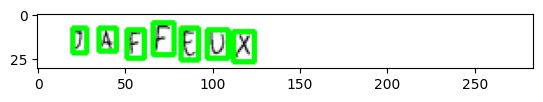

In [167]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00030.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 25ms/step
The model's prediction is:  BOUTET


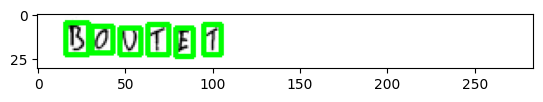

In [176]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00122.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 30ms/step
The model's prediction is:  UELOIAISINW


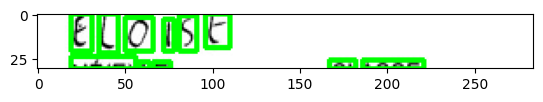

In [180]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00216.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

## Testing for the accuracy on whole test dataset

In [218]:
test_df = pd.read_csv('../Handwriting-Recognition/dataset/written_name_test_v2.csv')
test_df

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
...,...,...
41365,TEST_41366.jpg,ALEXANE
41366,TEST_41367.jpg,PEREIRA-SILVA
41367,TEST_41368.jpg,LAURENT
41368,TEST_41369.jpg,DEFFENSE


In [219]:
test_df.dropna(axis=0, inplace=True)
test_df = test_df[test_df['IDENTITY'] != 'UNREADABLE']


In [220]:
X_test = test_df.iloc[:, 0]
y_test = test_df.iloc[:, 1]
X_test

0         TEST_0001.jpg
1         TEST_0002.jpg
2         TEST_0003.jpg
3         TEST_0004.jpg
4         TEST_0005.jpg
              ...      
41365    TEST_41366.jpg
41366    TEST_41367.jpg
41367    TEST_41368.jpg
41368    TEST_41369.jpg
41369    TEST_41370.jpg
Name: FILENAME, Length: 41289, dtype: object

In [225]:
total_char = 0
correct_char = 0
correct_word = 0
for i in range(test_df.shape[0]):
    print(X_test[i])
    letters,image = get_letters(f"../Handwriting-Recognition/dataset/test/{X_test[i]}")
    pred = get_word(letter)
    
    total_char += len(y_test[i])
    
    for j in range(min(len(pred), len(y_test[i]))):
        if pred[j] == y_test[i]:
            correct_char += 1
    
    if pred == y_test[i]:
        correct_word += 1

print(f"Correct characters predicted : %.3f%%%" %(correct_char*100/total_char))
print(f"Correct words predicted : %.3f%%%" %(correct_word*100/test_df.shape[0]))



TEST_0001.jpg
1/1 [==============================] - 0s 21ms/step
TEST_0002.jpg
1/1 [==============================] - 0s 24ms/step
TEST_0003.jpg
1/1 [==============================] - 0s 32ms/step
TEST_0004.jpg
1/1 [==============================] - 0s 31ms/step
TEST_0005.jpg
1/1 [==============================] - 0s 23ms/step
TEST_0006.jpg
1/1 [==============================] - 0s 54ms/step
TEST_0007.jpg
1/1 [==============================] - 0s 25ms/step
TEST_0008.jpg
1/1 [==============================] - 0s 26ms/step
TEST_0009.jpg
1/1 [==============================] - 0s 22ms/step
TEST_0010.jpg
1/1 [==============================] - 0s 24ms/step
TEST_0011.jpg
1/1 [==============================] - 0s 26ms/step
TEST_0012.jpg
1/1 [==============================] - 0s 24ms/step
TEST_0013.jpg
1/1 [==============================] - 0s 72ms/step
TEST_0014.jpg
1/1 [==============================] - 0s 22ms/step
TEST_0015.jpg
1/1 [==============================] - 0s 23ms/step
TEST_0016.

UnboundLocalError: local variable 'y' referenced before assignment